# PMT calibration

In [1]:
from __future__ import print_function

### Revision

In [2]:
import time
print(time.strftime("%d/%m/%Y"),' ',time.strftime("%H:%M:%S"))

29/10/2016   17:17:01


### Dependencies

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import tables
import pandas as pd
import time

In [5]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
matplotlib.style.use('ggplot')

In [6]:
pp = %env PYTHONPATH
print(pp)
#from Nh5 import *

/Users/hernando/Software/root/lib:/Users/hernando/Software/lib:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Core:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Config:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Sierpe


### DB  

In [7]:
icdat = '/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/NEWMC/'
ifdat = 'nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5'
h5in =tables.open_file(icdat+ifdat,'a')
# h5in

In [8]:
# DB position of the (ordered) SiPMs 
sipmdb = h5in.root.Sensors.DataSiPM
pmtdb = h5in.root.Sensors.DataPMT

print('DB for a SIPM index {}, {}'.format(0,pmtdb[0]))
positions = map(lambda i: pmtdb[i][2], range(12))
# positions

DB for a SIPM index 0, (0, 1, [-23.9414005279541, 65.77850341796875, -10000.0], 0.001641481856365, -22.916799545288086)


### SiPM calibration data

In [9]:
indir='/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/NEW/pmtcalib/'
irun='2070'
infile='pmtCal_corrLED_R'+irun

In [10]:
# input calibration data: dark current and led
import calib as sc
called = sc.CalData(indir+infile+'spe.txt',nsensors=12)
#caldark = sc.CalData(indir+infile+'_dark.txt')

loaded calibration data from file /Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/NEW/pmtcalib/pmtCal_corrLED_R2070spe.txt
number of sensors with data 12


In [11]:
# create pdf file to put the figures
from matplotlib.backends.backend_pdf import PdfPages
pdf = None

In [12]:
# take the reference values
xbins = called.xbins
indexes = called.indexes

## Calibration

In [13]:
#chi2,pss = sc.cal_fit_ngauss(called,indexes,ngauss=3)
ps0 = np.array([35000., 0., 22., 1., 7., 7.])
bounds = ((0., -10., 10., 0.0, 2., 2.),(200000., 10., 40., 2., 15., 15.))

chi2,pss = sc.cal_fit_poissongauss(called, indexes, ngauss=4, ps0=ps0, bounds=bounds)
zpss = zip(indexes,pss)

fitting data...


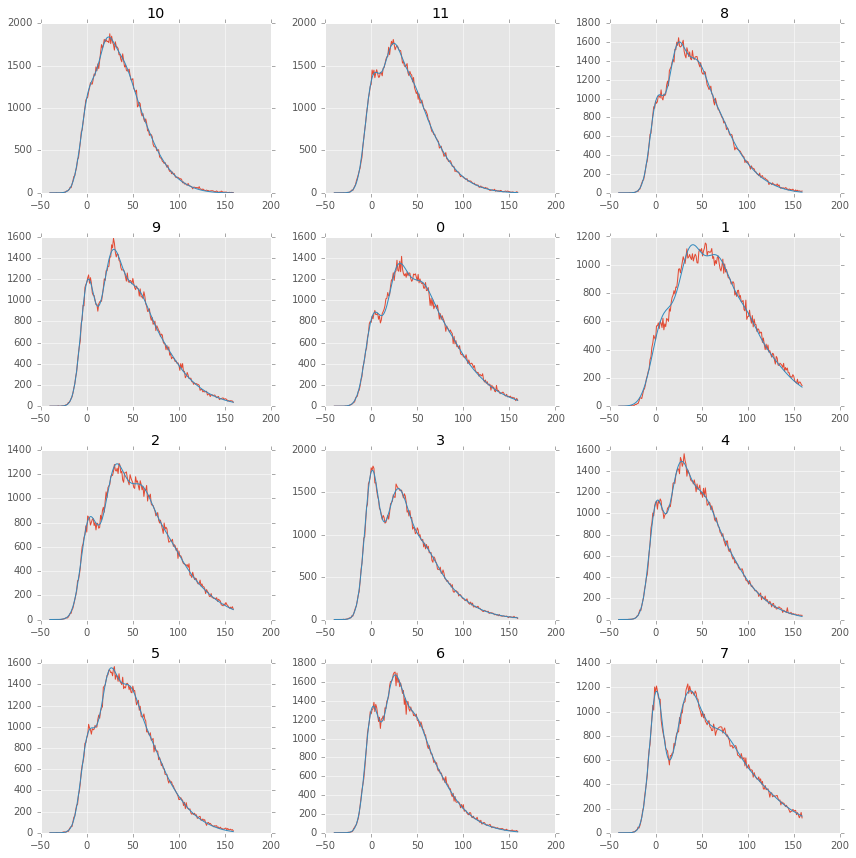

In [14]:
pdf = None
pdf = PdfPages(indir+'calf_R'+irun+'_pg_fits.pdf')
fun = sc.ffun_poissongauss
fig = sc.polo_cal_fit(called,indexes,pss,fun,xrange=(-40.,160.))
if (pdf): pdf.savefig(fig)
pdf.close()

In [15]:
pan = sc.cal_fit_poissongauss_panda(indexes, chi2, pss)

In [16]:
pan

,chi2,gain,indexes,noise,noise-pe,ntot,pedestal,pes
0,1.042918,18.554207,10,8.070318,5.678811,119791.606228,1.003943,1.862270
1,0.843477,20.339556,11,7.823648,7.338144,119862.556362,0.574413,1.713464
2,1.027726,21.290163,8,7.489499,6.428845,119839.164266,0.941050,2.000000
3,0.952397,25.595318,9,7.493263,8.668848,119756.495973,0.582095,1.777030
4,1.413511,25.445354,0,8.533152,7.854472,119466.297337,1.777872,2.000000
5,3.208962,29.181949,1,11.662437,6.116734,118220.472878,7.354958,2.000000
6,1.222103,27.098479,2,8.632018,8.192807,119543.012059,2.038419,2.000000
7,1.102050,26.448700,3,7.643450,9.995281,119824.920662,0.292679,1.366480
8,0.949827,24.127421,4,7.633746,8.392562,119664.042857,0.391942,1.863183
9,0.899992,21.897588,5,7.883509,6.158800,119714.433294,1.312987,2.000000


In [18]:
pan.to_hdf(indir+'calf_R'+irun+'_pg_panda.h5','df',mode='w',format='table',data_columns=True)
pan.to_csv(indir+'calf_R'+irun+'_pg_panda.csv')

That's all folks!